# Выбор реактора

[К оглавлению примеров](_contents.ipynb)

In [1]:
# Начальная настройка рабочей среды. Запустите эту ячейку перед началом работы!

# Загрузка пакетов
import numpy as np # Работа с массивами
import matplotlib.pyplot as plt # Графики
from mpl_toolkits.mplot3d import axes3d #3d-графики
# Выбор варианта отображения графиков:
# графики будут встраиваться в блокнот:
%matplotlib inline
# графики в отдельном окне:
# %matplotlib
# графики в блокноте, с возможностью масштабирования:
# %matplotlib nbagg

# Более крупный шрифт для графиков по умолчанию
from matplotlib import rcParams
rcParams.update({'font.size': 18})

import scipy.optimize as so # Пакет с методами оптимизации
import scipy

import sympy as sp # Пакет символьной математики
sp.init_printing() # Включить отображение выражений sympy в виде математических формул

# Обход проблемы с отображением матриц - определяем функцию для их печати
from IPython.display import  Math
def printMatrix(m):
    """
    Функция для вывода в блокнот матриц SymPy.
    Использование: printMatrix(Матрица)
    """
    return Math(sp.latex(m))

Химическая реакция: $𝐴\to𝐵$ может проводиться в реакторах двух типов:

 - Реактор I типа обеспечивает более высокую степень превращения (80%), однако себестоимость переработки в нем выше
 
 - Второй реактор обеспечивает степень превращения 66.7%, но обеспечивает более низкую себестоимость переработки
 
Стоимость сырья: 5 у.е./кмоль

Требуется синтезировать схему установки с производительностью 10 кмоль/час продукта 𝐵, обеспечивающую минимум совокупных затрат (стоимость переработки + стоимость сырья)

![Суперструктура](pics/two_reactors_superstructure.png "Суперструктура для выбора реактора")


Зависимость себестоимости переработки в реакторах задается степенными функциями (моделируется эффект масштаба).

- Для реактора I: $5.5 (x_1)^{0.6} $  у.е./час
- Для реактора II: $4.0 (x_2)^{0.6} $  у.е./час

## Нелинейная модель

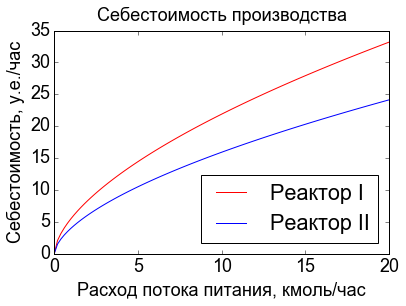

In [2]:
x = np.linspace(0, 20, 101)
plt.plot(x, 5.5 * x**0.6, 'r-', label='Реактор I')
plt.plot(x, 4.0 * x**0.6, 'b-', label='Реактор II')
plt.title('Себестоимость производства', y=1.02, fontsize=18)
plt.xlabel('Расход потока питания, кмоль/час')
plt.ylabel('Себестоимость, у.е./час')
plt.legend(loc='best');
#plt.savefig('two_reactors_cost.png', bbox_inches='tight');

Постановка задачи оптимизации:

$$ C = 5.5 x_1^{0.6} + 4.0 x_2 ^{0.6} + 5x_1 + 5x_2 \to \min$$

\begin{cases}
0.8 x_1 + 0.667 x_2 = 10 \\
x_1 \ge 0\\
x_2 \ge 0
\end{cases}

In [3]:
x1 = lambda x2: (10 - 2/3 * x2) / 0.8

In [4]:
Cost = lambda x2 : 5.5 * x1(x2)**0.6 + 4.0 * x2**0.6 + 5 * x1(x2) + 5 * x2

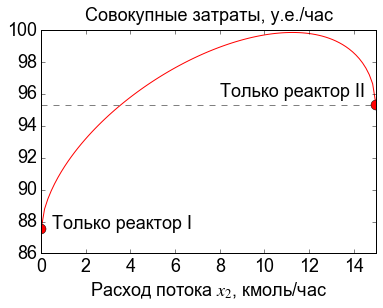

In [5]:
x2 = np.linspace(0, 15, 101)
plt.plot(x2, Cost(x2), 'r-', label='Совокупные затраты')
plt.title('Совокупные затраты, у.е./час', y=1.02, fontsize=18)
plt.xlabel('Расход потока $x_2$, кмоль/час')
plt.xlim((0, 15))
plt.axhline(Cost(15), linestyle='dashed', color='gray')
plt.annotate('Только реактор I', xy=(0, Cost(0)), xytext=(0.5, Cost(0)))
plt.annotate('Только реактор II', xy=(15, Cost(15)), xytext=(8, Cost(15) + .5))
ends = np.array([0, 15])
plt.plot(ends, Cost(ends), 'ro', ms=10);

plt.savefig('two_reactors_total_cost.png', bbox_inches='tight', dpi=200);

## Кусочно-линейная аппроксимация

In [10]:
# Исходные данные для аппроксимации затрат:
x_1 = np.linspace(0, 10 / 0.8, 101)
c_1 = 5.5 * x_1**0.6

x_2 = np.linspace(0, 10 / (2 / 3), 101)
c_2 = 4.0 * x_2**0.6

# Коэффициенты для уравнений регрессии:
(k1, b1) = scipy.polyfit(x_1, c_1, deg=1)
(k2, b2) = scipy.polyfit(x_2, c_2, deg=1)

print('Уравнение затрат на производство для реактора I: %.2f * x1 + %.2f' % (k1, b1))
print('Уравнение затрат на производство для реактора II: %.2f * x2 + %.2f' % (k2, b2))

Уравнение затрат на производство для реактора I: 1.74 * x1 + 4.72
Уравнение затрат на производство для реактора II: 1.18 * x2 + 3.83


In [7]:
# Функции для линейной аппроксимации:
C1 = lambda x: k1 * x + b1
C2 = lambda x: k2 * x + b2

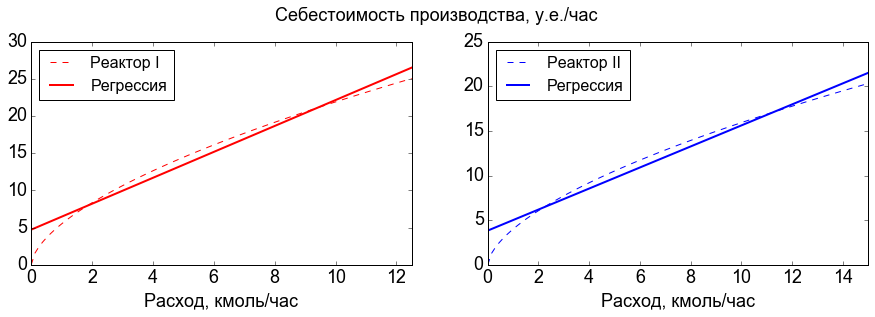

In [8]:
plt.subplots(nrows=1, ncols=2)

# График линейной аппроксимации для Реактора I

plt.subplot(121)
plt.plot(x_1, c_1, 'r-', linestyle='dashed', label='Реактор I')
plt.plot(x_1, C1(x_1), 'r-', label='Регрессия', linewidth=2)
plt.xlim((0, 10/0.8))
plt.xlabel('Расход, кмоль/час')
plt.legend(loc='best', fontsize=16);

# График линейной аппроксимации для Реактора II

plt.subplot(122)
plt.plot(x_2, c_2, 'b-', linestyle='dashed', label='Реактор II')
plt.plot(x_2, C2(x_2), 'b-', label='Регрессия', linewidth=2)
plt.xlim((0, 10 * 1.5))
plt.xlabel('Расход, кмоль/час')
plt.legend(loc='best', fontsize=16);

plt.suptitle('Себестоимость производства, у.е./час', y=1.02, fontsize=18)
plt.gcf().set_size_inches(15,4);

#plt.savefig('two_reactors_fixedcost.png', dpi=300, bbox_inches='tight');

## Линейная аппроксимация

In [13]:
# Исходные данные для аппроксимации затрат:
x_1 = np.linspace(0, 10 / 0.8, 101)
c_1 = 5.5 * x_1**0.6

x_2 = np.linspace(0, 10 / (2 / 3), 101)
c_2 = 4.0 * x_2**0.6

# Коэффициенты для уравнений регрессии:
(k1_, pcov) = so.curve_fit(lambda x, k: k * x, x_1, c_1)
(k2_, pcov) = so.curve_fit(lambda x, k: k * x, x_2, c_2)

print('Уравнение затрат на производство для реактора I: %.2f * x1 ' % (k1_,))
print('Уравнение затрат на производство для реактора II: %.2f * x2 ' % (k2_,))



Уравнение затрат на производство для реактора I: 2.31 * x1 
Уравнение затрат на производство для реактора II: 1.56 * x2 


In [14]:
# Функции для линейной аппроксимации:
C1_ = lambda x: k1_ * x
C2_ = lambda x: k2_ * x


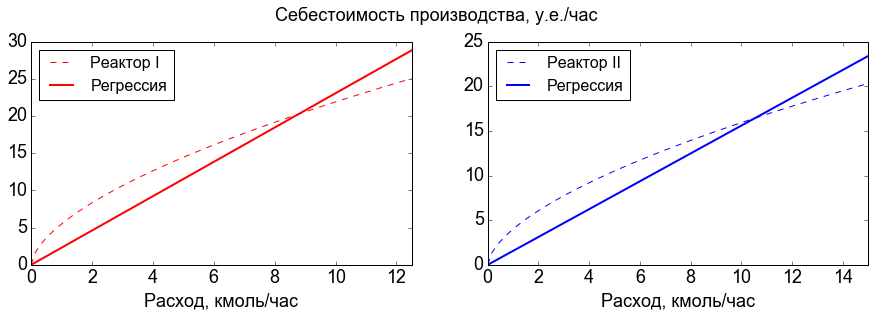

In [16]:
plt.subplots(nrows=1, ncols=2)

# График линейной аппроксимации для Реактора I

plt.subplot(121)
plt.plot(x_1, c_1, 'r-', linestyle='dashed', label='Реактор I')
plt.plot(x_1, C1_(x_1), 'r-', label='Регрессия', linewidth=2)
plt.xlim((0, 10/0.8))
plt.xlabel('Расход, кмоль/час')
plt.legend(loc='best', fontsize=16);

# График линейной аппроксимации для Реактора II

plt.subplot(122)
plt.plot(x_2, c_2, 'b-', linestyle='dashed', label='Реактор II')
plt.plot(x_2, C2_(x_2), 'b-', label='Регрессия', linewidth=2)
plt.xlim((0, 10 * 1.5))
plt.xlabel('Расход, кмоль/час')
plt.legend(loc='best', fontsize=16);

plt.suptitle('Себестоимость производства, у.е./час', y=1.02, fontsize=18)
plt.gcf().set_size_inches(15,4);

plt.savefig('two_reactors_linearcost.png', dpi=300, bbox_inches='tight');